---
title: Exploring why native executables produced with Mandrel 23.0 are bigger than with Mandrel 22.3
summary: >
  Starting with Quarkus 3.2, the default Mandrel version was updated from 22.3 to 23.0.
  This update introduced various improvements but also resulted in larger native executables.
  To understand the reasons behind this size increase, a comprehensive analysis was conducted, attributing it to specific changes in Mandrel's code base.
date: "2023-10-10T13:56:45+03:00"
lastmod: "2023-10-10T17:44:42+03:00"
draft: true  # Is this a draft? true/false
toc: true  # Show table of contents? true/false
type: post  # Do not modify.
tags: 
  - native 
  - graalvm
  - mandrel
  - metrics
  - quarkus

# Generate markdown from this file using
# jupyter nbconvert index.ipynb --to markdown --NbConvertApp.output_files_dir=.
---

Starting with Quarkus 3.2 the default Mandrel version was updated from 22.3 to 23.0.

This update brought a number of bugfixes as well as new features like:

1. Better support for profiling and debugging using `perf` and `gdb`.
2. Finer control over the monitoring features included in the native executable.
3. Support for more JFR events.

However, it also brought an unwanted side effect.
The native executables produced with Mandrel 23.0 are bigger than the ones produced with Mandrel 22.3.
To better understand why that happens we perform a thorough analysis to attribute the size increase to specific changes in Mandrel's code base.

## TL;DR

According to our analysis the binary size increase is attributed to three distinct changes, all of which are well justified:

1. [Skipping constant folding of reflection methods with side effects](https://github.com/oracle/graal/pull/5156).
2. [Reducing the number of stores that are executed by the serial GC write barriers to improve performance by reducing the number of cache misses](https://github.com/oracle/graal/pull/5330).
3. [Enabling code alignment to compensate for the performance penalty of Intel's jump conditional code erratum](https://github.com/oracle/graal/commit/4de58f1b3c484213951622c03d74f3435a20c4ef#diff-991a434bbfc9a6af5514e4609380d5fbfe7618585d5b1b3f11fa2a7431ca7ab0L1388-R1388).

## Better understanding what is different between the generated native executables

The first step in our analysis is to understand where the binary size increase comes from.
Usually such an increase is attributed to one of the following:

1. More code being generated, due to more code becoming reachable.
2. More code being generated, due to more aggressive inlining.
3. More data being stored in the image heap, due to more objects being reachable.
4. More data being stored in the image heap, due to more types being registered for reflection thus requiring more code metadata to be stored.

To perform the analysis we use the [Quarkus startstop test](https://github.com/quarkus-qe/quarkus-startstop) (specifically commit `a8bae846881607e376c7c8a96116b6b50ee50b70`) which generates, starts, tests, and stops small Quarkus applications and measures various time-related metrics (e.g. time-to-first-OK-request) and memory usage.
We get the test with:

```shell
git clone https://github.com/quarkus-qe/quarkus-startstop
cd quarkus-startstop
git checkout a8bae846881607e376c7c8a96116b6b50ee50b70
```

and build it with:

```shell
mvn clean package -Pnative -Dquarkus.version=3.2.6.Final\
    -Dquarkus.native.builder-image=quay.io/quarkus/ubi-quarkus-mandrel-builder-image:jdk-17
```

changing the builder image tag to `22.3-java17` for building with Mandrel 22.3.

Looking at the build output (generated by Quarkus in `target/my-app-native-image-sources/my-app-build-output-stats.json`) the main differences between the two builds are in the following metrics:

| Mandrel version | 22.3.3.1 | 23.0.1.2 | Increase %
| --- | --- | --- | --- |
| Image Heap Size | 28807168 | 29499392 | 2.4
| Image Code Area | 27680208 | 29625424 | 7
| Total Image Size | 56826648 | 59467728 | 4.6
| Classes registered for reflection | 645 | 4317 | 570

Hinting that any of the reasons 1-4 mentioned above is possible.

### Dashboards

GraalVM and Mandrel provide the `-H:+DashboardAll` and `-H:+DashboardJson` flags that can be used to generate dashboards that contain more information about the generated native executable.
The resulting dashboard contains a number of metrics and looks like this:

```json
{
  "points-to": {
    "type-flows": [
      ...
    ]
  },
  "code-breakdown": {
    "code-size": [
      {
        "name": "io.smallrye.mutiny.CompositeException.getFirstOrFail(Throwable[]) Throwable",
        "size": 575
      },
      ...
    ]
  },
  "heap-breakdown": {
    "heap-size": [
      {
        "name": "Lio/vertx/core/impl/VerticleManager$$Lambda$bf09d38f5d19578a0d041ffd0a524c1cbe1843df;",
        "size": 24,
        "count": 1
      },
      ...
    ]
  }
}
```

Using the aforementioned flags we generate dashboards using both Mandrel 22.3 and 23.0 and compare the results.

To generate the dashboards using Mandrel 23.0 we use the following command:

```shell
mvn package -Pnative \
  -Dquarkus.version=3.2.6.Final \
  -Dquarkus.native.builder-image=quay.io/quarkus/ubi-quarkus-mandrel-builder-image:jdk-17 \
  -Dquarkus.native.additional-build-args=-H:+DashboardAll,-H:+DashboardJson,-H:DashboardDump=path/to/23.0.dashboard.json
```

Similarly to generate the dashboards using Mandrel 22.3 we use the following command:

```shell
mvn package -Pnative \
  -Dquarkus.version=3.2.6.Final \
  -Dquarkus.native.builder-image=quay.io/quarkus/ubi-quarkus-mandrel-builder-image:22.3-java17 \
  -Dquarkus.native.additional-build-args=-H:+DashboardAll,-H:+DashboardJson,-H:DashboardDump=path/to/22.3.dashboard.json
```

Note: Make sure to change `path/to/` to the path where you would like the dashboard json files to be stored, each file is about 370MB big.

### Analyzing and visualizing the data

To process the data from the dashboards we used a Jupyter notebook, like we do in this article.
To grab the notebook follow [this link](assets/examples/posts/mandrel-23-0-image-size-increase/quarkus-size-22-3-23-0.ipynb).

For those willing to use a spreadsheet instead, a CSV file can be created to facilitate the analysis in a spreadsheet.
E.g. using `jq`:

```shell
jq -r -s '(["Name", "22.3 size", "23.0 size"], (map(."code-breakdown"."code-size") | flatten | group_by(.name) | map({name: .[0].name, size22: .[0].size, size23: .[1].size})[] | [.name, .size22, .size23])) | @csv' 22.3.dashboard.json 23.0.dashboard.json > analysis.csv
```

#### Loading the data from the json files

In [1]:
import json
import pandas as pd

# load data from JSON file
with open('22.3.dashboard.json', 'r') as f:
    data22_3 = json.load(f)
with open('23.0.dashboard.json', 'r') as f:
    data23_0 = json.load(f)

# create dataframes from json data
df22_3 = pd.DataFrame(data22_3)
df23_0 = pd.DataFrame(data23_0)



## Key Observations

The key questions we want to answer using the aforementioned data are:

1. Is the code area bigger due to more methods being compiled?
2. Is the code area bigger due to more code being generated per method?
3. Is the heap image bigger because we store more objects in it? 
4. Is the heap image bigger because we store more metadata?

### Code Area Size Increase

We first answer the code area related questions. 

#### Is the code area bigger due to more methods being compiled?

To answer this question we get the two lists of the compiled methods and compare their sizes:

In [2]:
# Get code-size lists from dataframes
code_size_22_3 = df22_3['code-breakdown']['code-size']
code_size_23_0 = df23_0['code-breakdown']['code-size']

print("Compiled methods with 22_3:", len(code_size_22_3))
print("Compiled methods with 23_0:", len(code_size_23_0))

Compiled methods with 22_3: 46298
Compiled methods with 23_0: 46299


The results indicate that the answer is no.
In both cases the number of compiled methods is the same (off by 1).
As a result the code size increase is not coming from more methods becoming reachable and compiled.

#### Is the code area bigger due to more code being generated per method?

To answer this question we calculate the percentage difference between the compiled methods:

In [3]:
import matplotlib.pyplot as plt

# create dataframes from code_size lists
code_df22_3 = pd.DataFrame(code_size_22_3).rename(columns={'size': 'size-22.3'})
code_df23_0 = pd.DataFrame(code_size_23_0).rename(columns={'size': 'size-23.0'})

# merge dataframes
merged_df = pd.merge(code_df22_3, code_df23_0, on='name', how='outer').fillna(0)

# create column with size increase as percentage skipping entries with 0 size
percentage_increase = lambda row: (
    ((row['size-23.0'] - row['size-22.3']) / row['size-22.3']) * 100 
    if row['size-22.3'] > 0 and row['size-23.0'] > 0 
    else 0
)
merged_df['size-increase'] = merged_df.apply(percentage_increase, axis=1)

We count the number of methods, the number of those that didn't change size, the number of those that their size increased, and the number of those that their size decreased:

In [4]:
total_compiled_methods = len(merged_df)
print(f"Total number of compiled methods: {total_compiled_methods}")
zero_increase_count = (merged_df['size-increase'] == 0).sum()
zero_increase_percent = (zero_increase_count / total_compiled_methods) * 100
print(f"Number of methods that their compiled size remains the same: {zero_increase_count} ({zero_increase_percent:.2f}%)")
positive_increase_count = (merged_df['size-increase'] > 0).sum()
positive_increase_percent = (positive_increase_count / total_compiled_methods) * 100
print(f"Number of methods that their compiled size increased: {positive_increase_count} ({positive_increase_percent:.2f}%)")
negative_increase_count = (merged_df['size-increase'] < 0).sum()
negative_increase_percent = (negative_increase_count / total_compiled_methods) * 100
print(f"Number of methods that their compiled size decreased: {negative_increase_count} ({negative_increase_percent:.2f}%)")

Total number of compiled methods: 48476
Number of methods that their compiled size remains the same: 13947 (28.77%)
Number of methods that their compiled size increased: 33351 (68.80%)
Number of methods that their compiled size decreased: 1178 (2.43%)


The results indicate that 68.8% of the compiled methods are bigger when compiled by 23.0 in comparison to when they are compiled by 22.3.
But how much bigger?
To answer this we print a histogram of the size increase:

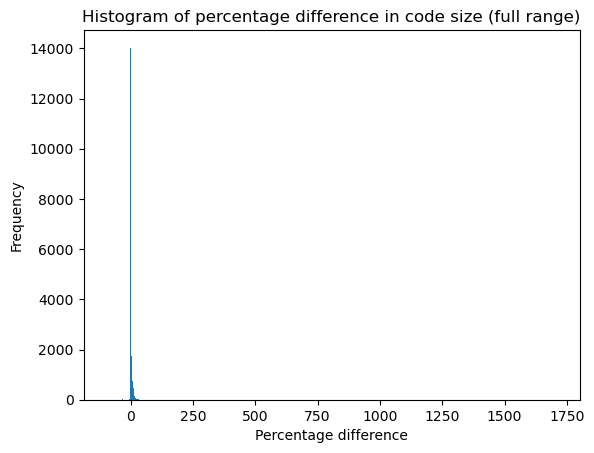

In [5]:
# plot histogram
plt.hist(merged_df['size-increase'], bins="auto")
plt.xlabel('Percentage difference')
plt.ylabel('Frequency')
plt.title('Histogram of percentage difference in code size (full range)')
plt.show()

We observe that due to a large number of methods retaining the same size and due to some outliers the histogram is hard to read.
So we remove the methods with no size changes and limit our focus in the range [-5, 25]:

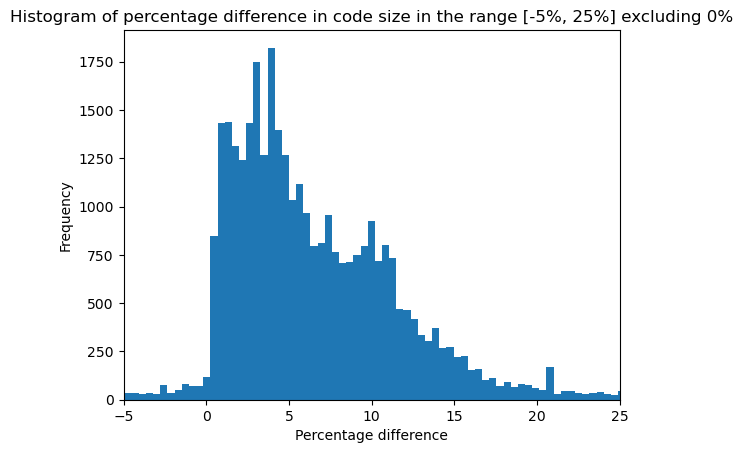

In [6]:
# create column with size increase as percentage skipping entries with 0 size
zero_filter = lambda row: row['size-increase'] if row['size-increase'] != 0 else None
merged_df['size-increase'] = merged_df.apply(zero_filter, axis=1)

# drop rows with None values
merged_df = merged_df.dropna()

# plot histogram
plt.hist(merged_df['size-increase'], bins="auto")
plt.xlim(-5, 25)
plt.xlabel('Percentage difference')
plt.ylabel('Frequency')
plt.title('Histogram of percentage difference in code size in the range [-5%, 25%] excluding 0%')
# show the plot
plt.show()

This plot shows that the majority of the affected methods get a code size increase between 0 and 10 %, which is inline with the overall size increase we observe in the code area.

##### Why?

To see why the same methods get compiled to larger machine code when using Mandrel 23.0 we first inspected how many methods are getting inlined in each case.
To do so, we build the native executables with debug info generation enabled using the `-Dquarkus.native.debug.enabled=true` parameter.
To make sure that inline DIEs are included when building with Mandrel 22.3 we also pass the `-Dquarkus.native.additional-build-args=-H:-OmitInlinedMethodDebugLineInfo` option, e.g.:

```shell
mvn clean package -Pnative -Dquarkus.version=3.2.6.Final\
    -Dquarkus.native.builder-image=quay.io/quarkus/ubi-quarkus-mandrel-builder-image:jdk-17\
    -Dquarkus.native.debug.enabled=true\
    -Dquarkus.native.additional-build-args=-H:-OmitInlinedMethodDebugLineInfo
```

After the image is built we count the number of _inlined_ Debug Info Entries (DIEs) using the following command:

```shell
readelf --debug-dump=info quarkus-runner | grep -i "DW_TAG_inlined_subroutine" | wc -l
```

The results are shown in the table below:

| Mandrel version | 22.3 | 23.0 | Increase % |
| --- | --- | --- | --- |
| Inlined methods | 2798414 | 2817686 | 0.69 % |

While they indicate a slight increase in the number of inlined methods between Mandrel 22.3 and 23.0, the increase is so small that it doesn't align with the overall code size increase.

As a next step, we hand-picked a number of methods with different code sizes in the generated native executables and inspected their disassembled code (using `gdb`).

For example inspecting `InstrumentedUnpooledUnsafeNoCleanerDirectByteBuf.allocateDirect(int)` from `io.netty.buffer.UnpooledByteBufAllocator` using:

```gdb
(gdb) x/20i 'io.netty.buffer.UnpooledByteBufAllocator$InstrumentedUnpooledUnsafeNoCleanerDirectByteBuf::allocateDirect(int)'
```

we see that the one extra byte comes from an additional `nop` between two calls.

**Mandrel 22.3**

```asm
sub    $0x18,%rsp
cmp    0x8(%r15),%rsp
jbe    0x96ad8f
mov    %rdi,0x8(%rsp)
mov    %esi,%edi
mov    %esi,0x14(%rsp)
call   0xb7e870
nop
call   0x756e10
nop
```

**Mandrel 23.0**

```asm
sub    $0x18,%rsp
cmp    0x8(%r15),%rsp
jbe    0x96ad8f
mov    %rdi,0x8(%rsp)
mov    %esi,%edi
mov    %esi,0x14(%rsp)
call   0xb7e870
nop
nop                     // <==== extra nop
call   0x756e10
nop
```

We observed this pattern in multiple methods which is an indication of some code alignment change.
However, there were also methods with increased compiled code size without having an increased number of `nop`s, hinting that the code size increase is not caused by a single change as we confirm in [Attributing Binary Size Increase to Specific Code Changes](#attributing-binary-size-increase-to-specific-code-changes).

### Image Heap Size Increase

Upon initial inspection, it was noted that there was an increase of approximately 650KB in the image heap size.
As a result next we opted to answer whether:

1. The heap image is bigger because we store more objects in it? 
2. The heap image is bigger because we store more metadata?

#### Is the heap image bigger because we store more objects in it?

Using the dashboard data we first checked whether the number of objects in the image heap is different between the two versions:

In [7]:
# Get heap-size lists from dataframes
heap_size_22_3 = df22_3['heap-breakdown']['heap-size']
heap_size_23_0 = df23_0['heap-breakdown']['heap-size']

# create dataframes from heap_size lists
heap_df22_3 = pd.DataFrame(heap_size_22_3).rename(columns={'size': 'size-22.3', 'count': 'count-22.3'})
heap_df23_0 = pd.DataFrame(heap_size_23_0).rename(columns={'size': 'size-23.0', 'count': 'count-23.0'})

print("Number of objects in image heap with 22.3: ", heap_df22_3['count-22.3'].sum())
print("Number of objects in image heap with 23.0: ", heap_df23_0['count-23.0'].sum())

Number of objects in image heap with 22.3:  340870
Number of objects in image heap with 23.0:  348063


We observe that the image generated with 22.3 has ~7000 (or roughly 2%) more objects in the image heap.
We then check to see if these additional objects are from different types being instantiated:

In [8]:
print("Types in image heap with 22.3:", len(heap_size_22_3))
print("Types in image heap with 23.0:", len(heap_size_23_0))

Types in image heap with 22.3: 3681
Types in image heap with 23.0: 3679


The results indicate that the number of types in the image heap remain about the same, hinting that 23.0 instantiates more objects of the same types in the image heap.
To see which types are those seeing the larger, in terms of heap size, increase in the image heap we run:

In [9]:
# merge dataframes
merged_heap_df = pd.merge(heap_df22_3, heap_df23_0, on='name', how='outer').fillna(0)
merged_heap_df['count-diff'] = merged_heap_df['count-23.0'] - merged_heap_df['count-22.3']
merged_heap_df['size-diff'] = merged_heap_df['size-23.0'] - merged_heap_df['size-22.3']
# get top 10 types with the biggest difference in occupied heap size
merged_heap_df.sort_values(by=['size-diff'], ascending=False).head(10)[['name', 'count-diff', 'size-diff']]

,name,count-diff,size-diff
1340,[B,2042.0,894704.0
2384,Ljava/lang/invoke/DirectMethodHandle;,1293.0,71920.0
2901,Ljava/lang/String;,2032.0,65024.0
3684,Ljdk/internal/module/ServicesCatalog$ServicePr...,1058.0,42320.0
2582,[Ljava/lang/Object;,246.0,36472.0
898,[Ljava/lang/String;,9.0,28024.0
1297,Ljava/lang/invoke/MethodType;,276.0,15456.0
3238,Ljava/util/concurrent/ConcurrentHashMap$Node;,274.0,13152.0
1065,Ljava/util/HashMap;,146.0,10512.0
3244,[Ljava/lang/Class;,261.0,9680.0


The results indicate an increase of ~870KB of bytes in byte arrays, which unfortunately is not very informative, especially combined with the size of other types significantly differing between the two versions (possibly due to GraalVM internal code changes which result in different allocation patterns).

#### Is the heap image bigger because we store more metadata?

As shown in [Better understanding what is different between the generated native executables](#better-understanding-what-is-different-between-the-generated-native-executables) there appears to be a significant increase in the number of types registered for reflection (645 in Mandrel 22.3 vs. 4317 in Mandrel 23.0).
This, along with the reported (in the `native-image` output) increase of code metadata, initially led us to think that there is some change in Mandrel that results in more types being registered for reflection.
In the end, as discussed in [Attributing Binary Size Increase to Specific Code Changes](#attributing-binary-size-increase-to-specific-code-changes), contrary to our intuition, the increase is not related to the increase in the reported types registered for reflection which is due to [a fix in the way the reported types registered for reflection are measured](https://github.com/oracle/graal/commit/23d70b802b2dbc9b7d2324a31141c32b6575083f#diff-54ef73a23b10bd907d5869cc88b651fae7fef0467ccfaf8f50472cdd1e114eceR385).
Instead, the increase of the code metadata stored in the image heap is due to [skipping constant folding of reflection methods with side effects](https://github.com/oracle/graal/pull/5156), a fix introduced in 23.0 to prevent undesired effects when folding invocations using reflection.

## Attributing Binary Size Increase to Specific Code Changes

At this point, we have a rough understanding of what is different in the generated native executables, but we still don't know why.
Is this increase in the size of native executables well justified?

To answer this question, we decided to detect the code base changes that resulted in the observed behaviors.
To do so, we used `git bisect`, marking the 22.3 release's commit as _good_ and the 23.0 release's commit as _bad_.
For each commit, we built an instance of Mandrel and compiled our test application to see the code and heap area size.
If the sizes matched the ones from 22.3, we marked the commit as _good_ otherwise we marked it as _bad_.
During this process, we noticed that there were commits resulting in binary sizes bigger than the ones generated with 22.3 but smaller than 23.0.
This confirmed our expectation that the binary size increase was the result of more than one change in the code base.
To reduce the `git bisect` cost we noted down the code and heap area sizes for each tested commit hash.
Then using that info, we replayed the bisect process a few times using the output of `git bisect log` and changing which commits we considered _good_, once we identified the first, second, and so forth change contributing to the binary size increase.

### Identified Causes of Code Size Increase

The above process led us to the conclusion that the binary size increase is mainly mainly the result of the following three changes:

- [**Skipping constant folding of reflection methods with side effects**](https://github.com/oracle/graal/pull/5156): A fix introduced in 23.0 to prevent undesired effects when folding invocations using reflection (e.g. triggering build time initialization of classes that should be run time initialized).
  This change is responsible for the image heap size increase.

- [**Reducing the number of stores that are executed by the serial GC write barriers to improve performance by reducing the number of cache misses**](https://github.com/oracle/graal/pull/5330): This change essentially adds two additional instructions, a `cmpb   $0x0,0x30(%rcx,%rax,1)` and a `je`, to each inlined instance of the serial GC write barrier.
  The aim of this change is to avoid unnecessary stores in the GC write barriers in order to reduce cache line invalidations and improve performance.
  According to our measurements, the total impact of this change is ~1MB increase of code area in our test case which inlines the write barrier 90697 times when using Mandrel 22.3 and 93686 times when using Mandrel 23.0.
  To measure the number the barrier was inlined we inspect the number of breakpoint locations set in `gdb` when running `b CardTable.java:91`, i.e. when setting a breakpoint in `com.oracle.svm.core.genscavenge.remset.CardTable#setDirty`.
  E.g.:

  ```gdb
  (gdb) b CardTable.java:91
  Breakpoint 1 at 0x407574: CardTable.java:91. (93686 locations)
  ```

- [**Enabling code alignment to compensate for the performance penalty of Intel's Jump Conditional Code Erratum**](https://github.com/oracle/graal/commit/4de58f1b3c484213951622c03d74f3435a20c4ef#diff-991a434bbfc9a6af5514e4609380d5fbfe7618585d5b1b3f11fa2a7431ca7ab0L1388-R1388): According to [Intel's white paper about "Mitigations for Jump Conditional Code Erratum"](https://www.intel.com/content/dam/support/us/en/documents/processors/mitigations-jump-conditional-code-erratum.pdf):

  > Software can compensate for the performance effects of the workaround for this erratum with optimizations that align the code such that jump instructions (and macro-fused jump instructions) do not cross 32-byte boundaries or end on a 32-byte boundary.
  > Such aligning can reduce or eliminate the performance penalty caused by the transition of execution from Decoded ICache to the legacy decode pipeline.

  As a result, this change results in an increased number of `nop` instructions in the generated code, but can result in up to 4% performance improvements according to the same document:
  
  > Intel has observed performance effects associated with the workaround ranging from
0-4% on many industry-standard benchmarks.
  > In subcomponents of these benchmarks, Intel has observed outliers higher than the 0-4% range.
  > Other workloads not observed by Intel may behave differently.
  > Intel has in turn developed software-based tools to minimize the impact on potentially affected applications and workloads.
  
   According to our measurements, the total impact of this change is ~900KB in our test case.

## Conclusion

In conclusion, the increase in the size of native executables produced with Mandrel 23.0 compared to Mandrel 22.3 can be attributed to the above three specific changes in the Mandrel code base.

While these changes do contribute to the increase in native executable size, they also come with performance and correctness benefits.
Therefore, the larger executables are a trade-off to ensure better application performance and avoid undesired side effects.